In [1]:
!pip install ortools

In [2]:
from ortools.linear_solver import pywraplp
import networkx as nx
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [ ]:
# Test Function

def LinearProgrammingExample():
    """Linear programming sample."""
    # Instantiate a Glop solver, naming it LinearExample.
    solver = pywraplp.Solver.CreateSolver("GLOP")
    if not solver:
        return

    # Create the two variables and let them take on any non-negative value.
    x = solver.NumVar(0, solver.infinity(), "x")
    y = solver.NumVar(0, solver.infinity(), "y")

    print("Number of variables =", solver.NumVariables())

    # Constraint 0: 5x + 20y <= 400.
    solver.Add(5 * x + 20 * y <= 400.0)

    # Constraint 1: 10x + 15y <= 450.
    solver.Add(10 * x + 15 * y <= 450.0)

    # Constraint 2: x >= 0..
    solver.Add(x >= 0.0)

    # Constraint 2: y >= 0..
    solver.Add(y >= 0.0)

    print("Number of constraints =", solver.NumConstraints())

    # Objective function: 3x + 4y.
    solver.Maximize(45 * x + 80 * y)

    # Solve the system.
    print(f"Solving with {solver.SolverVersion()}")
    status = solver.Solve()

    if status == pywraplp.Solver.OPTIMAL:
        print("Solution:")
        print(f"Objective value = {solver.Objective().Value():0.1f}")
        print(f"x = {x.solution_value():0.1f}")
        print(f"y = {y.solution_value():0.1f}")
    else:
        print("The problem does not have an optimal solution.")

    print("\nAdvanced usage:")
    print(f"Problem solved in {solver.wall_time():d} milliseconds")
    print(f"Problem solved in {solver.iterations():d} iterations")


LinearProgrammingExample()

Number of variables = 2
Number of constraints = 4
Solving with Glop solver v9.14.6206
Solution:
Objective value = 2200.0
x = 24.0
y = 14.0

Advanced usage:
Problem solved in 0 milliseconds
Problem solved in 2 iterations


In [3]:
def graph_to_lp(n, edges):
  lp = {
      "Objective":{},
      "constraints": [],
      "bounds": {}
  }

  # Objectiver: Minimize sum(x_v)
  for v in range(n):
    lp["Objective"][f"x_{v}"] = 1

  # Constraints: x_u + x_v >= 1  foe each edge (u, v)
  for u, v in edges:
    lp["constraints"].append(f"x_{u} + x_{v} >= 1")

  #Bounds: 0 <= x_v <= 1
  for v in range(n):
    lp["bounds"][f"x_{v}"] = (0, 1)

  return lp

In [4]:
def solve_LP(lp):
    solver = pywraplp.Solver.CreateSolver("GLOP")
    if not solver:
        return

    # creating variables
    variables = {}
    for v in lp["Objective"]:
        variables[v] = solver.NumVar(lp["bounds"][v][0], lp["bounds"][v][1], v)

    # adding constraints
    for constraint_str in lp["constraints"]:
        # Split the constraint string at the inequality sign
        if ">=" in constraint_str:
            parts = constraint_str.replace(" ", "").split(">=")
            inequality = ">="
        elif "<=" in constraint_str:
            parts = constraint_str.replace(" ", "").split("<=")
            inequality = "<="
        elif "=" in constraint_str:
            parts = constraint_str.replace(" ", "").split("=")
            inequality = "="
        else:
            print(f"Warning: Could not parse constraint: {constraint_str}")
            continue

        lhs_str = parts[0]
        rhs = float(parts[1])

        # Use a regular expression to find variable names and their coefficients
        import re
        terms = re.findall(r"([-+]?\s*\d*\.?\d*)\s*([a-zA-Z_]\w*)", lhs_str)

        lhs = 0
        for coeff_str, var_name in terms:
            if coeff_str.strip() == "" or coeff_str.strip() == "+":
                coeff = 1
            elif coeff_str.strip() == "-":
                coeff = -1
            else:
                coeff = float(coeff_str)

            if var_name in variables:
                lhs += coeff * variables[var_name]
            else:
                print(f"Warning: Variable '{var_name}' not found in variables dictionary.")


        if inequality == ">=":
            solver.Add(lhs >= rhs)
        elif inequality == "<=":
            solver.Add(lhs <= rhs)
        elif inequality == "=":
            solver.Add(lhs == rhs)


    # Objective Function
    solver.Minimize(sum(lp["Objective"][v] * variables[v] for v in lp["Objective"]))


    # Solve the system.
    print(f"Solving with {solver.SolverVersion()}")
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        solution_set = []
        # print("Solution:")
        # print(f"Objective value = {solver.Objective().Value():0.1f}")
        # Extract solution values for all variables
        for var_name, var in variables.items():
            solution_set.append((var_name, var.solution_value()))
            # print(f"{var_name} = {var.solution_value():0.1f}")
        return solution_set
    else:
        print("The problem does not have an optimal solution.")
    print("\nAdvanced usage:")
    print(f"Problem solved in {solver.wall_time():d} milliseconds")
    print(f"Problem solved in {solver.iterations():d} iterations")

In [5]:
def vertex_cover_by_lp(solution_set):
  vertex_cover = []

  for i in range(len(solution_set)):
    # LP Rounding
    if solution_set[i][1] >= 0.5:
      vertex_cover.append(int(solution_set[i][0].split("_")[1]))

  return vertex_cover

In [6]:
def draw_graph(vertex_cover):
    vertex_cover = list(vertex_cover)
    nx.draw(
            graph,
            pos=nx.spring_layout(graph, seed=46),
            with_labels=True,
            node_color=["orange" if n in vertex_cover else "lightblue" for n in graph.nodes()],
            node_size=800,
            font_color="black",
            font_size=12,
            edge_color="grey",
            width=2
        )
    plt.title("LP Vertex Cover")
    plt.show()

In [7]:
df_n10 = pd.read_csv('/content/2_approx_vertex_cover_results.csv')
df_n10.head()

,n,m,BruteForce_Size,BruteForce_Time(s),Approx_Size,Approx_Time(s),Approx_Factor
0,10,10,5,0.000201,6,0.000043,1.200000
1,10,20,6,0.000377,8,0.000024,1.333333
2,10,30,7,0.000488,8,0.000033,1.142857
3,10,40,8,0.000633,10,0.000074,1.250000
4,10,50,9,0.000940,10,0.000079,1.111111


In [8]:
df_n20 = pd.read_csv('/content/vertex_cover_results_n20.csv')
df_n20.head()

,n,m,BruteForce_Size,BruteForce_Time,Greedy_Size,Greedy_Time,Approximation_Factor
0,20,20,8,0.087279,16,0.000042,2.000
1,20,40,11,0.447901,16,0.000074,1.455
2,20,60,13,0.747023,20,0.000114,1.538
3,20,80,13,0.779360,18,0.000154,1.385
4,20,100,15,1.033197,18,0.000217,1.200


In [9]:
selected_columns1 = ["n", "m", "Approx_Size", "Approx_Time(s)"]
selected_columns2 = ["n", "m", "Greedy_Size", "Greedy_Time"]

df_n10 = df_n10[selected_columns1].head(4)
df_n20 = df_n20[selected_columns2].head(4)

df_comparison = pd.concat([df_n10, df_n20], axis=0)

# Replacing NaN values from Approx columns with Greedy values
df_comparison["Greedy_Size"] = df_comparison["Greedy_Size"].fillna(df_comparison["Approx_Size"])
df_comparison["Greedy_Time"] = df_comparison["Greedy_Time"].fillna(df_comparison["Approx_Time(s)"])

# Drop Greedy columns
df_comparison = df_comparison.drop(columns=["Approx_Size", "Approx_Time(s)"])

df_comparison.head(8)

,n,m,Greedy_Size,Greedy_Time
0,10,10,6.0,0.000043
1,10,20,8.0,0.000024
2,10,30,8.0,0.000033
3,10,40,10.0,0.000074
0,20,20,16.0,0.000042
1,20,40,16.0,0.000074
2,20,60,20.0,0.000114
3,20,80,18.0,0.000154


[10, 20] [10, 20, 30, 40, 50, 60, 70, 80]

Running experiment for n=10, m=10
Solving with Glop solver v9.14.6206
LP Vertex Cover: [1, 5, 6, 7, 8, 9]
Size: 6, Time: 0.002583 sec


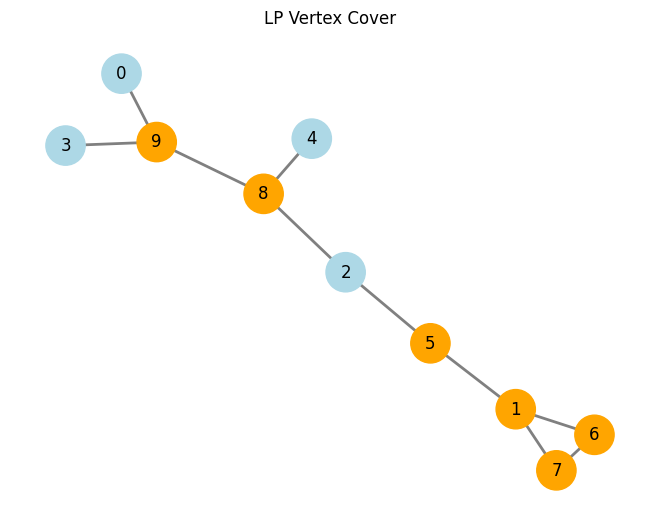


Running experiment for n=10, m=20
Solving with Glop solver v9.14.6206
LP Vertex Cover: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Size: 9, Time: 0.001351 sec


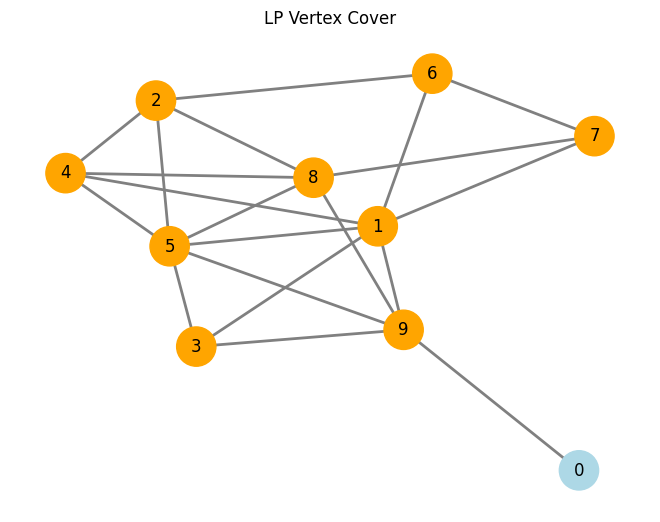


Running experiment for n=10, m=30
Solving with Glop solver v9.14.6206
LP Vertex Cover: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Size: 10, Time: 0.001085 sec


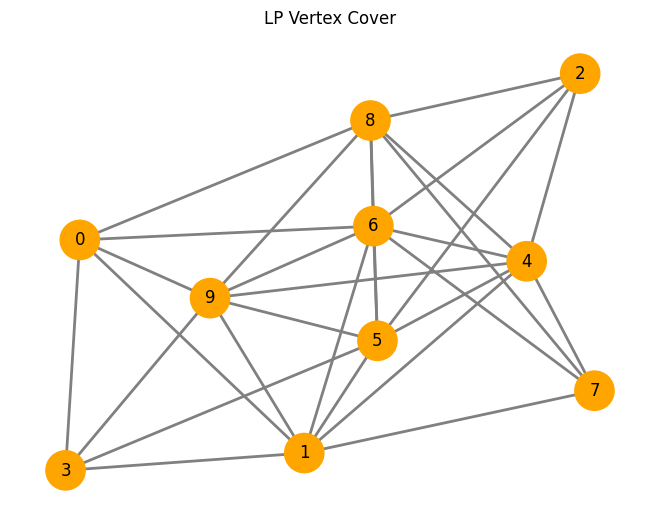


Running experiment for n=10, m=40
Solving with Glop solver v9.14.6206
LP Vertex Cover: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Size: 10, Time: 0.001456 sec


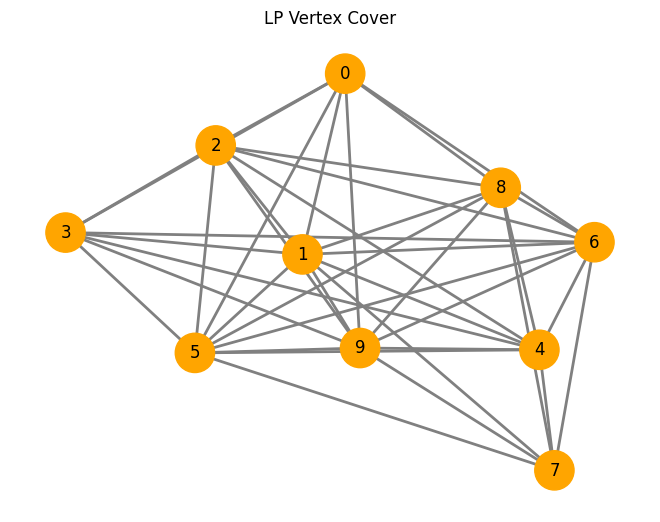


Running experiment for n=20, m=20
Solving with Glop solver v9.14.6206
LP Vertex Cover: [1, 2, 3, 4, 7, 15, 16, 17]
Size: 8, Time: 0.000912 sec


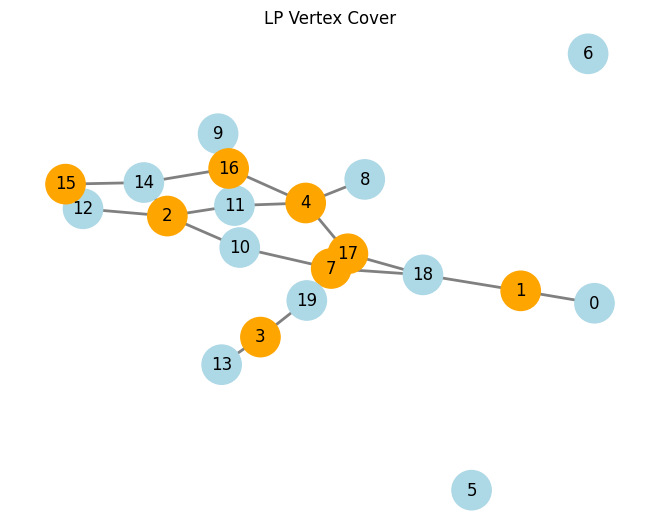


Running experiment for n=20, m=40
Solving with Glop solver v9.14.6206
LP Vertex Cover: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19]
Size: 18, Time: 0.001426 sec


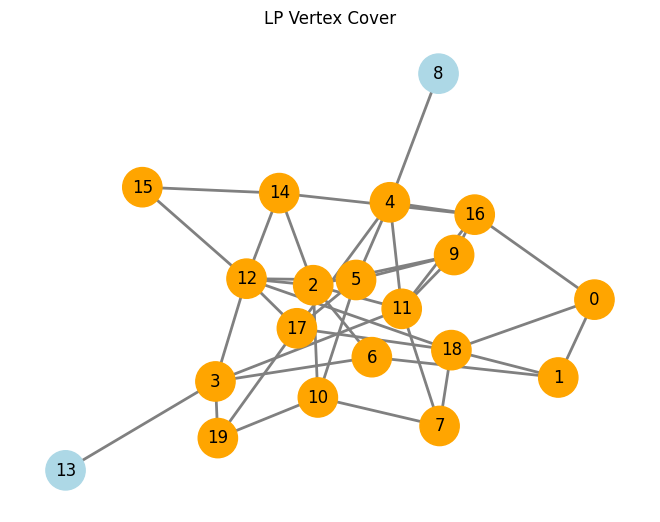


Running experiment for n=20, m=60
Solving with Glop solver v9.14.6206
LP Vertex Cover: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Size: 20, Time: 0.001622 sec


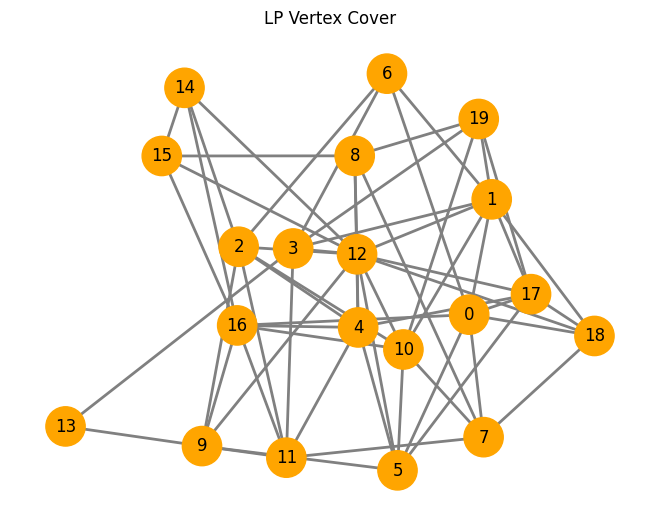


Running experiment for n=20, m=80
Solving with Glop solver v9.14.6206
LP Vertex Cover: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Size: 20, Time: 0.002819 sec


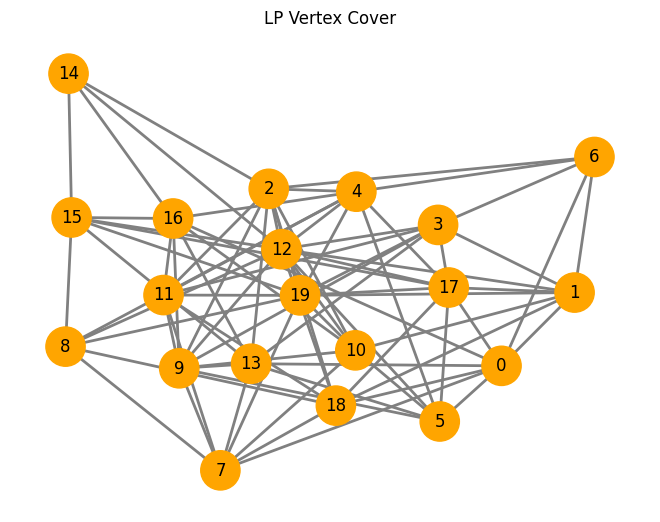

[[10, 10, 6, 0.002582550048828125], [10, 20, 9, 0.0013513565063476562], [10, 30, 10, 0.001085042953491211], [10, 40, 10, 0.0014564990997314453], [20, 20, 8, 0.0009121894836425781], [20, 40, 18, 0.0014257431030273438], [20, 60, 20, 0.0016217231750488281], [20, 80, 20, 0.002818584442138672]]


In [11]:
# --- Read from file ---
with open("input.txt", "r") as f:
    lines = f.readlines()
    n_values = list(map(int, lines[0].strip().split(",")))  # first line = number of nodes
    m_values = list(map(int, lines[1].strip().split(",")))  # second line = edge counts

print(n_values, m_values)

# Pair n with only the first 4 valid m values
nm_pairs = []
for n in n_values:
    valid_ms = [m for m in m_values if m % n == 0]  # filter valid m values
    nm_pairs.extend((n, m) for m in valid_ms[:4])  # take only first 4

results = []
for n, m in nm_pairs:
    print("\n==============================")
    print(f"Running experiment for n={n}, m={m}")
    print("==============================")
    # Generate random graph
    graph = nx.gnm_random_graph(n, m, seed=46)
    nodes = list(graph.nodes())
    edges = list(graph.edges())

    # Converting graph to LP
    lp = graph_to_lp(n, edges)
    # print(lp)

    # Solving problem using GLOP Solver and measuring time
    start_time = time.time()
    solution_set = solve_LP(lp)
    vertex_cover_lp = vertex_cover_by_lp(solution_set)
    time_lp = time.time() - start_time

    print(f"LP Vertex Cover: {vertex_cover_lp}")
    print(f"Size: {len(vertex_cover_lp)}, Time: {time_lp:.6f} sec")

    # Record results
    results.append([n, m, len(vertex_cover_lp), time_lp])

    # Graph
    draw_graph(vertex_cover_lp)

print(results)

In [12]:
# Convert list to a dataframe
df_lp = pd.DataFrame(results, columns=["n", "m", "lp_cover_size", "lp_time"])

# Merge with df_comparison on n and m
df_comparison = df_comparison.merge(df_lp, on=["n", "m"], how="left")

# Add approx_factor column
df_comparison["size_comparison_factor"] = df_comparison.apply(lambda row: row["lp_cover_size"] / row["Greedy_Size"], axis=1)
df_comparison["time_comparison_factor"] = df_comparison.apply(lambda row: row["lp_time"] / row["Greedy_Time"], axis=1)


df_comparison

,n,m,Greedy_Size,Greedy_Time,lp_cover_size,lp_time,size_comparison_factor,time_comparison_factor
0,10,10,6.0,0.000043,6,0.002583,1.000000,59.845304
1,10,20,8.0,0.000024,9,0.001351,1.125000,56.680000
2,10,30,8.0,0.000033,10,0.001085,1.250000,33.218978
3,10,40,10.0,0.000074,10,0.001456,1.000000,19.706452
4,20,20,16.0,0.000042,8,0.000912,0.500000,21.718797
5,20,40,16.0,0.000074,18,0.001426,1.125000,19.266799
6,20,60,20.0,0.000114,20,0.001622,1.000000,14.225642
7,20,80,18.0,0.000154,20,0.002819,1.111111,18.302496


In [13]:
df_comparison.to_csv("greedy_lp_vertex_cover_comparison.csv", index=True)